In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from prettytable import PrettyTable
from tqdm import tqdm_notebook

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [2]:
#this CSV file contains clean data
data = pd.read_csv('./Chicago-clean-data.csv')
data.index = pd.DatetimeIndex(data.Date)
data = data.sort_index()

In [3]:
print('Range of dates: {} to {}'.format(data.Date.min(), data.Date.max()))

Range of dates: 01/01/2001 01:00:00 PM to 12/31/2019 12:58:00 AM


In [4]:
data['Date']=pd.to_datetime(data['Date'])

In [5]:
data['Year'] = data.index.year
data['Month'] = data.index.month
data['dayOfWeek'] = data.index.dayofweek
data['dayOfMonth'] = data.index.day
data['dayOfYear'] = data.index.dayofyear

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [7]:
data_tr = data.loc['2001-01-01':'2017-12-31']
data_test = data.loc['2018-01-1':'2018-12-31']

In [8]:
data.groupby([data['Date'].dt.year]).size()

Date
2001      3186
2002    328777
2003    449992
2004    446500
2005    429909
2006    426093
2007    416687
2008    402000
2009    369102
2010    351681
2011    333676
2012    319321
2013    291068
2014    258589
2015    243428
2016    251997
2017    248638
2018    245832
2019    238489
2020    148979
dtype: int64

In [9]:
listOfDist = list(data['District'].unique())

In [10]:
train_d = []
for district in listOfDist:
    df = data_tr[data_tr['District'] == district]
    df_gr = df.groupby(['Year', 'Month']).count()
    train_d.append(list(df_gr['Date'].values))

In [11]:
test_d = []
for district in listOfDist:
    df = data_test[data_test['District'] == district]
    df_gr = df.groupby(['Month']).count()
    test_d.append(list(df_gr['Date'].values))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

District: 1
Actuals: [372, 305, 337, 306, 372, 438, 434, 449, 405, 440, 375, 372]
Predictions: [360.21976, 359.01965, 331.80304, 317.97778, 322.1708, 355.0192, 448.40366, 455.4747, 444.0222, 413.7258, 412.5971, 396.49567]


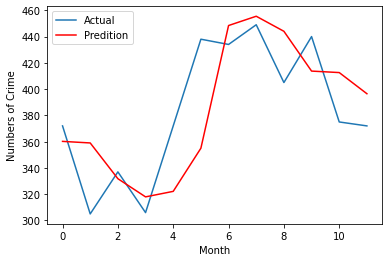

  0%|          | 0/12 [00:00<?, ?it/s]

District: 2
Actuals: [1138, 976, 1125, 1134, 1325, 1260, 1258, 1424, 1146, 1133, 996, 1155]
Predictions: [1186.3112, 1128.5398, 1030.9567, 1051.1962, 1119.3375, 1243.6742, 1308.5402, 1224.2998, 1391.5912, 1257.8159, 1153.5886, 1045.7927]


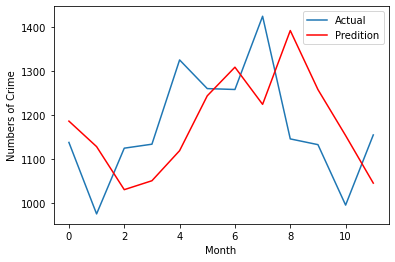

  0%|          | 0/12 [00:00<?, ?it/s]

District: 3
Actuals: [1231, 922, 1077, 1187, 1335, 1344, 1415, 1470, 1348, 1255, 1172, 1268]
Predictions: [1183.3934, 1160.7961, 1011.62115, 1011.8105, 1239.1943, 1326.121, 1381.9835, 1445.6088, 1415.8276, 1300.6575, 1281.7435, 1168.3827]


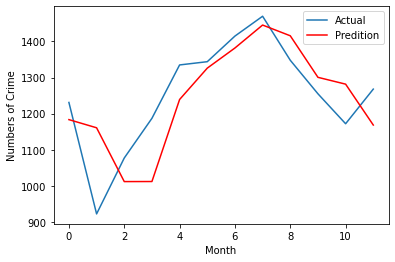

  0%|          | 0/12 [00:00<?, ?it/s]

District: 4
Actuals: [617, 529, 657, 674, 795, 747, 743, 675, 696, 590, 528, 566]
Predictions: [584.7915, 571.20135, 565.6394, 655.8901, 704.8401, 768.43384, 812.6109, 699.83044, 696.61194, 676.8044, 621.3561, 551.6536]


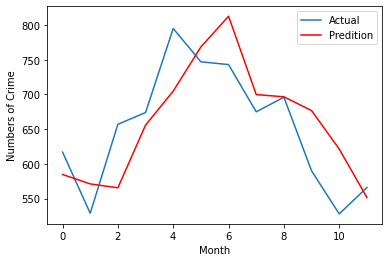

  0%|          | 0/12 [00:00<?, ?it/s]

District: 5
Actuals: [858, 768, 909, 887, 1055, 1078, 1068, 1094, 1038, 1029, 946, 920]
Predictions: [876.19556, 848.34894, 787.7549, 846.4654, 865.10535, 1041.205, 1081.4955, 1058.9333, 1048.6163, 1062.465, 1002.9312, 961.98517]


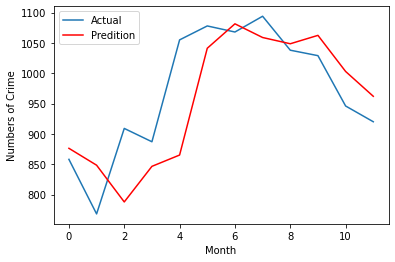

  0%|          | 0/12 [00:00<?, ?it/s]

District: 6
Actuals: [860, 725, 910, 978, 1102, 1100, 1137, 1198, 1093, 1092, 980, 981]
Predictions: [984.6086, 902.10236, 799.2034, 923.0732, 988.8904, 1047.9994, 1068.3285, 1087.5116, 1157.5204, 1119.1793, 1062.0477, 1000.9006]


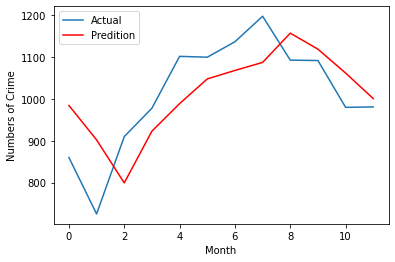

  0%|          | 0/12 [00:00<?, ?it/s]

District: 7
Actuals: [982, 899, 1028, 1066, 1166, 1170, 1177, 1291, 1096, 1130, 937, 1080]
Predictions: [1033.958, 1013.47156, 930.3153, 951.91693, 1067.999, 1156.7617, 1120.0709, 1153.1233, 1269.4916, 1146.5524, 1205.7863, 1012.38574]


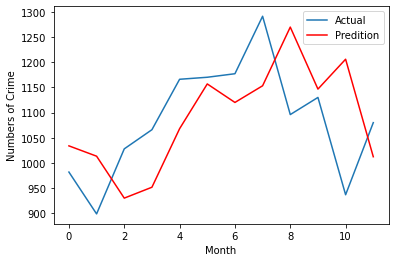

  0%|          | 0/12 [00:00<?, ?it/s]

District: 8
Actuals: [788, 650, 907, 960, 1044, 1074, 1056, 1029, 911, 876, 795, 879]
Predictions: [794.572, 761.5336, 706.55524, 887.5325, 945.92847, 1001.2212, 1051.1423, 1016.2228, 1003.4833, 924.6856, 886.7569, 811.6847]


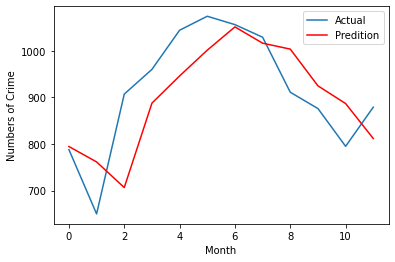

  0%|          | 0/12 [00:00<?, ?it/s]

District: 9
Actuals: [766, 662, 843, 772, 966, 947, 1011, 917, 853, 851, 749, 758]
Predictions: [809.9615, 763.4244, 694.9426, 761.1724, 772.2881, 882.0487, 988.4464, 979.31976, 921.24695, 863.39264, 827.7343, 770.6509]


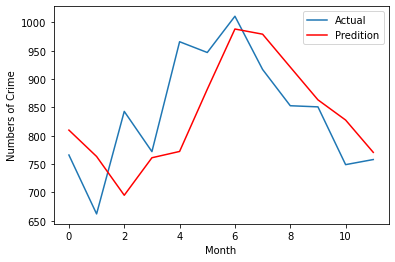

  0%|          | 0/12 [00:00<?, ?it/s]

District: 10
Actuals: [1149, 1050, 1219, 1191, 1390, 1369, 1473, 1401, 1261, 1253, 1173, 1194]
Predictions: [1137.3389, 1132.7551, 1079.4952, 1168.0974, 1200.3513, 1323.8109, 1370.9901, 1376.825, 1409.3739, 1332.0302, 1238.4429, 1224.0562]


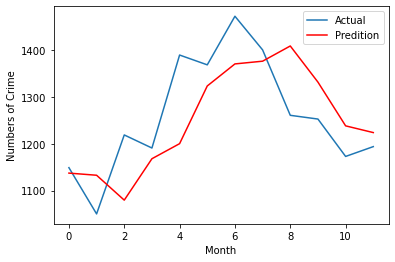

  0%|          | 0/12 [00:00<?, ?it/s]

District: 11
Actuals: [612, 531, 613, 718, 791, 786, 790, 792, 753, 810, 733, 789]
Predictions: [659.92725, 603.7306, 539.45953, 564.3486, 680.6897, 812.6166, 762.5018, 791.2726, 749.8885, 725.7276, 827.1391, 752.5517]


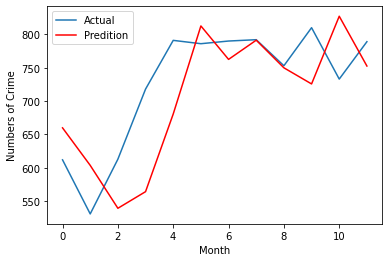

  0%|          | 0/12 [00:00<?, ?it/s]

District: 12
Actuals: [628, 480, 641, 558, 632, 591, 589, 648, 584, 585, 562, 622]
Predictions: [580.32117, 623.22235, 540.13574, 632.0148, 620.9061, 587.2757, 613.7361, 572.43365, 604.28986, 596.3621, 583.15546, 565.46454]


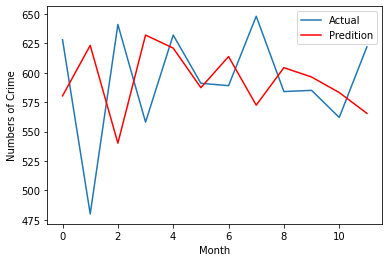

  0%|          | 0/12 [00:00<?, ?it/s]

District: 13
Actuals: [956, 782, 1009, 1070, 1297, 1161, 1328, 1346, 1154, 1009, 1005, 1003]
Predictions: [897.5124, 910.1182, 835.5906, 964.7333, 1018.18207, 1282.7716, 1278.3345, 1251.9276, 1357.5043, 1203.3538, 1076.8436, 983.29675]


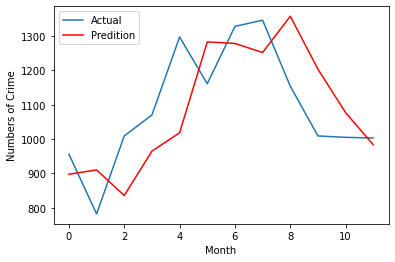

  0%|          | 0/12 [00:00<?, ?it/s]

District: 14
Actuals: [904, 723, 890, 876, 1067, 1088, 1038, 1082, 1027, 848, 818, 923]
Predictions: [915.2983, 883.4272, 794.0558, 916.5428, 929.1268, 943.9425, 1086.1571, 1048.5272, 1034.7224, 1044.404, 930.461, 839.6164]


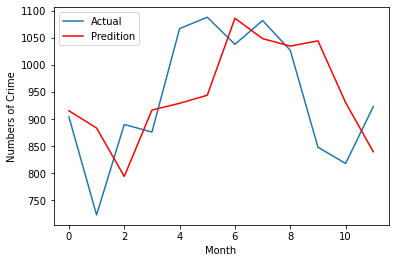

  0%|          | 0/12 [00:00<?, ?it/s]

District: 15
Actuals: [1023, 877, 1005, 1027, 1115, 1034, 1181, 1095, 1042, 1051, 911, 1017]
Predictions: [1017.10065, 994.1742, 936.6983, 1020.67224, 1034.9679, 1098.1821, 1049.8098, 1172.2833, 1167.6864, 1060.8304, 1056.5848, 949.48627]


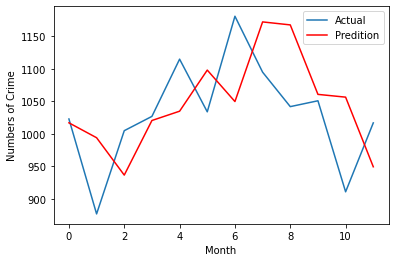

  0%|          | 0/12 [00:00<?, ?it/s]

District: 16
Actuals: [1139, 993, 1168, 1140, 1453, 1397, 1479, 1424, 1264, 1317, 1239, 1230]
Predictions: [1208.6051, 1155.1354, 1083.7976, 1075.2816, 1165.8301, 1337.9995, 1420.8746, 1412.0049, 1392.1665, 1338.171, 1278.525, 1240.3162]


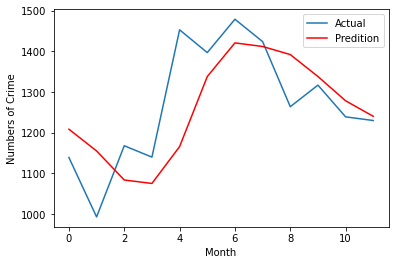

  0%|          | 0/12 [00:00<?, ?it/s]

District: 17
Actuals: [848, 720, 886, 878, 1100, 1062, 1080, 1001, 893, 918, 876, 782]
Predictions: [892.78314, 825.1781, 757.05615, 800.17126, 930.8825, 1031.7988, 1115.4259, 1010.5678, 1001.64636, 912.4891, 866.357, 872.73126]


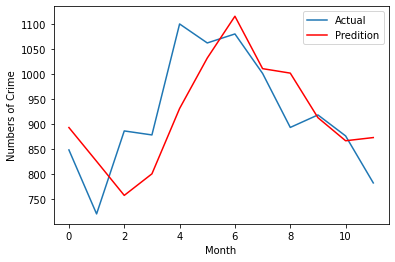

  0%|          | 0/12 [00:00<?, ?it/s]

District: 18
Actuals: [552, 473, 602, 502, 597, 628, 722, 731, 634, 631, 533, 541]
Predictions: [597.058, 557.81494, 490.70905, 569.4014, 563.9528, 580.5562, 656.725, 708.8498, 764.65375, 652.4471, 620.712, 554.0603]


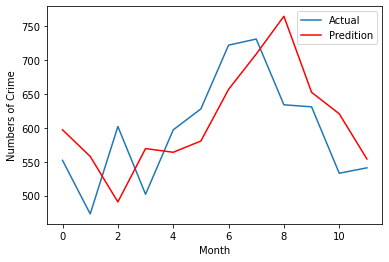

  0%|          | 0/12 [00:00<?, ?it/s]

District: 19
Actuals: [1360, 1125, 1458, 1417, 1748, 1598, 1576, 1653, 1468, 1574, 1330, 1306]
Predictions: [1229.0312, 1277.8016, 1200.128, 1345.833, 1475.9994, 1622.6019, 1643.6082, 1556.3588, 1603.5602, 1536.1267, 1502.8922, 1422.6276]


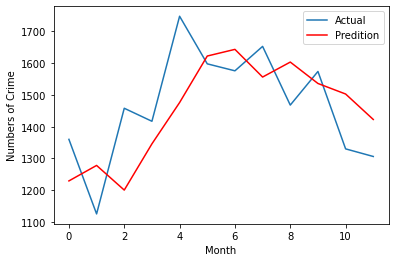

  0%|          | 0/12 [00:00<?, ?it/s]

District: 20
Actuals: [590, 483, 600, 603, 644, 627, 625, 606, 547, 610, 520, 619]
Predictions: [609.48846, 591.0862, 539.325, 586.70825, 590.58923, 618.38446, 624.4381, 613.7734, 600.29034, 568.5312, 598.82184, 548.7326]


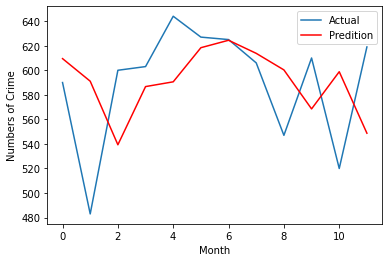

  0%|          | 0/12 [00:00<?, ?it/s]

District: 21
Actuals: [810, 735, 827, 880, 931, 1019, 1045, 1095, 1050, 1011, 820, 970]
Predictions: [840.4766, 762.7725, 726.9949, 786.9938, 939.9541, 935.75287, 1045.3541, 1096.1936, 1110.0928, 980.6074, 982.42865, 852.7941]


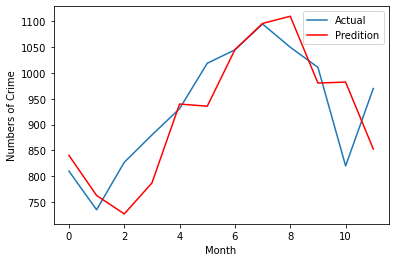

  0%|          | 0/12 [00:00<?, ?it/s]

District: 22
Actuals: [700, 600, 835, 726, 934, 844, 941, 856, 766, 758, 690, 718]
Predictions: [722.86066, 704.10394, 630.6858, 712.8349, 741.1074, 859.0206, 847.754, 928.7125, 855.9771, 823.4199, 770.65656, 707.7756]


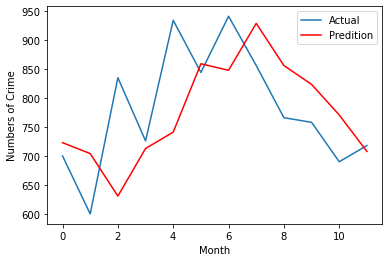

R-squared: 0.886
Mean Absolute Error:75.982
Median Absolute Error:67.358
Mean Squared Error:96.760


In [12]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(window, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # fit model
        model.fit(X, y, epochs=200, verbose=0)
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('District: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.xlabel("Month")
    plt.ylabel("Numbers of Crime")
    plt.legend(["Actual", "Predition"])
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new
    
print('R-squared: %.3f' %r2_score(testTot, predTot))
print('Mean Absolute Error:%.3f'%mean_absolute_error(testTot, predTot))
print('Median Absolute Error:%.3f'%median_absolute_error(testTot, predTot))
print('Mean Squared Error:%.3f'%mean_squared_error(testTot, predTot) ** .5)

# Transfer Learning 

In [13]:
data_test = data.loc['2019-01-1':'2019-12-31']

In [14]:
test_d = []
for district in listOfDist:
    df = data_test[data_test['District'] == district]
    df_gr = df.groupby(['Month']).count()
    test_d.append(list(df_gr['Date'].values))

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 1
Actuals: [331, 304, 303, 324, 366, 395, 381, 378, 322, 341, 275, 299]
Predictions: [381.40112, 350.51697, 323.9732, 311.17044, 322.73758, 349.93845, 384.5542, 392.429, 382.9603, 347.48257, 340.11273, 304.74506]


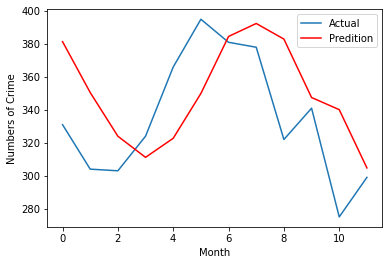

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 2
Actuals: [1066, 1036, 1081, 1106, 1243, 1274, 1256, 1333, 1113, 1113, 1103, 1086]
Predictions: [1072.7384, 1100.8466, 1038.2103, 1049.7067, 1098.5674, 1186.6295, 1255.8068, 1250.6786, 1301.6743, 1176.0674, 1125.0647, 1087.1183]


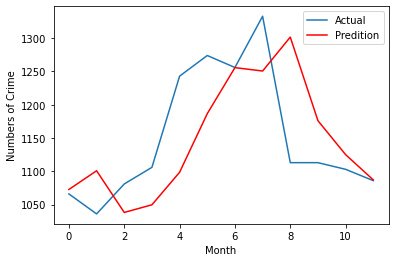

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 3
Actuals: [1100, 1060, 1093, 1139, 1245, 1335, 1315, 1244, 1114, 1205, 1098, 1135]
Predictions: [1206.1211, 1140.0259, 1082.98, 1059.7996, 1123.1943, 1200.9208, 1292.6382, 1324.4567, 1246.8146, 1159.5641, 1149.2037, 1127.6237]


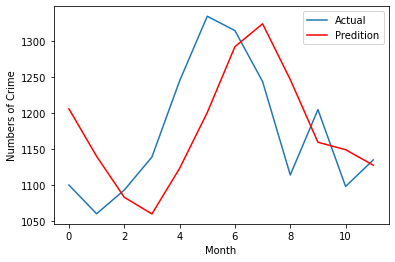

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 4
Actuals: [566, 531, 600, 611, 718, 674, 693, 717, 648, 653, 593, 613]
Predictions: [548.021, 570.1322, 540.85004, 576.55896, 607.99713, 674.6815, 693.5533, 677.22833, 711.4303, 666.3741, 648.2431, 609.56793]


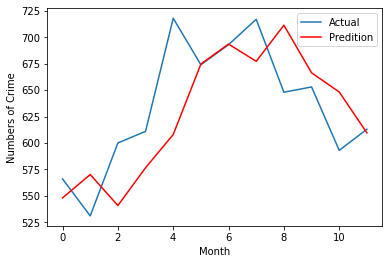

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 5
Actuals: [899, 786, 937, 946, 1004, 991, 1052, 1114, 983, 954, 810, 852]
Predictions: [923.3115, 891.44507, 824.7631, 869.34033, 937.09106, 984.2394, 998.8453, 1028.7883, 1088.6167, 1013.1525, 967.62634, 864.9693]


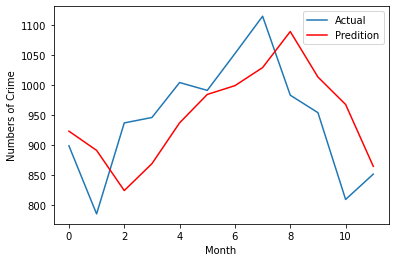

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 6
Actuals: [921, 872, 948, 841, 1077, 1076, 1149, 1193, 1174, 1037, 950, 973]
Predictions: [974.62396, 927.247, 883.7819, 911.56824, 872.0252, 986.7637, 1071.7129, 1122.9806, 1174.8436, 1178.5957, 1077.9437, 994.0098]


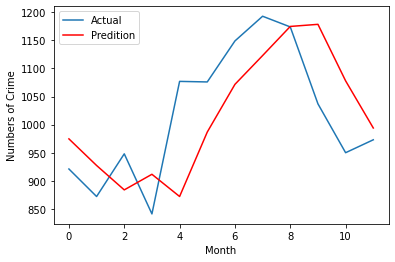

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 7
Actuals: [955, 854, 1045, 978, 1189, 1187, 1237, 1089, 1101, 1032, 965, 1019]
Predictions: [1016.1906, 1006.58234, 906.0659, 973.0278, 1001.1744, 1107.1239, 1177.6979, 1216.1024, 1123.7521, 1092.2277, 1037.8436, 984.1463]


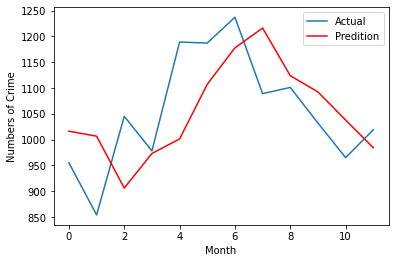

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 8
Actuals: [818, 722, 793, 862, 1024, 950, 1024, 968, 838, 881, 823, 797]
Predictions: [833.80286, 845.0291, 763.09393, 756.13336, 832.0841, 949.9079, 978.0338, 977.52, 990.9778, 890.6137, 861.2994, 837.72076]


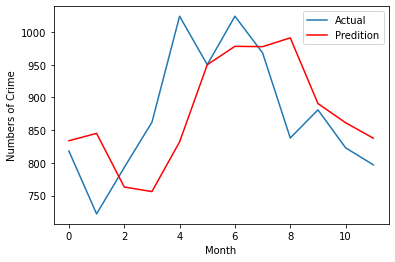

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 9
Actuals: [699, 703, 815, 794, 903, 879, 953, 936, 889, 810, 764, 820]
Predictions: [754.0761, 711.7402, 694.8322, 771.1935, 802.16614, 863.16046, 888.60406, 925.76483, 945.18805, 892.0069, 836.36237, 782.38025]


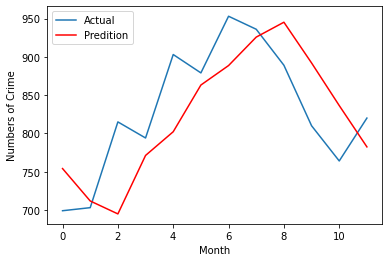

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 10
Actuals: [1130, 1088, 1101, 1120, 1240, 1203, 1331, 1411, 1257, 1237, 1151, 1146]
Predictions: [1163.7911, 1130.6451, 1089.025, 1074.121, 1109.9602, 1192.0419, 1217.6381, 1283.1886, 1371.2499, 1287.0603, 1240.5322, 1163.2963]


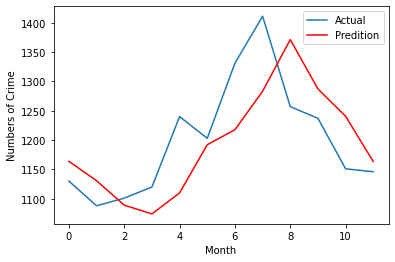

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 11
Actuals: [615, 545, 664, 608, 757, 902, 853, 799, 758, 796, 622, 727]
Predictions: [756.67175, 674.54376, 603.7096, 620.5367, 633.7608, 700.8583, 831.3996, 871.41547, 813.7468, 768.884, 771.7215, 684.5499]


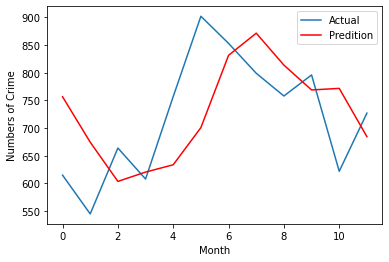

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 12
Actuals: [565, 512, 542, 606, 596, 586, 605, 590, 554, 477, 510, 543]
Predictions: [602.3424, 591.1363, 538.8434, 527.56177, 580.8426, 603.0296, 585.8473, 598.6248, 597.8282, 563.16583, 512.5998, 498.75916]


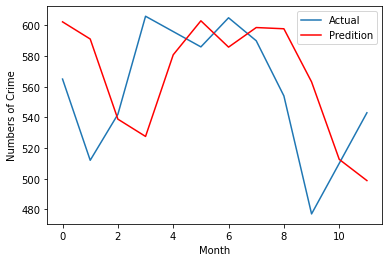

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 13
Actuals: [881, 889, 956, 1019, 1190, 1163, 1233, 1133, 1081, 1039, 932, 989]
Predictions: [988.33795, 916.70844, 884.738, 932.6525, 992.5006, 1113.9026, 1168.2848, 1199.7773, 1150.4869, 1094.8546, 1039.3384, 966.6887]


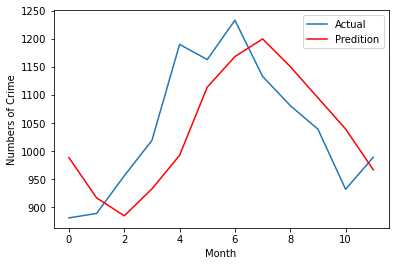

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 14
Actuals: [869, 827, 907, 959, 1123, 1004, 1126, 1046, 1014, 951, 832, 886]
Predictions: [885.2187, 892.4807, 835.753, 874.44336, 936.2902, 1051.0358, 1052.0706, 1058.011, 1079.5459, 1016.14056, 961.03296, 880.82513]


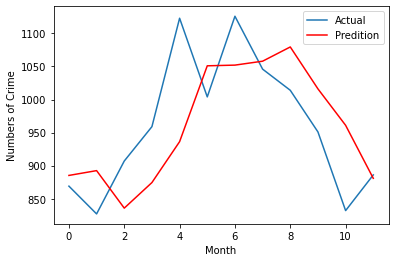

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 15
Actuals: [936, 877, 945, 983, 1036, 994, 1093, 1131, 1048, 1013, 950, 955]
Predictions: [962.87177, 970.43274, 897.9834, 905.4401, 967.8914, 1016.7492, 1007.736, 1054.3694, 1113.0721, 1058.4423, 1017.30634, 960.60065]


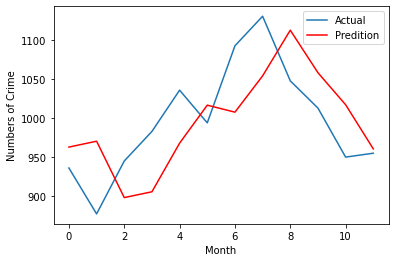

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 16
Actuals: [1109, 1091, 1166, 1241, 1452, 1455, 1521, 1455, 1352, 1308, 1207, 1164]
Predictions: [1212.3823, 1137.4662, 1091.904, 1137.2609, 1208.4283, 1356.8284, 1442.8947, 1495.4708, 1459.8322, 1374.4027, 1310.2195, 1228.9678]


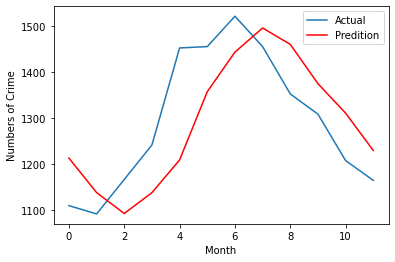

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 17
Actuals: [789, 705, 808, 769, 947, 1001, 942, 944, 967, 890, 750, 765]
Predictions: [815.847, 783.1857, 727.6895, 760.47156, 786.0822, 876.764, 970.45734, 957.984, 928.0037, 955.42584, 903.178, 815.2812]


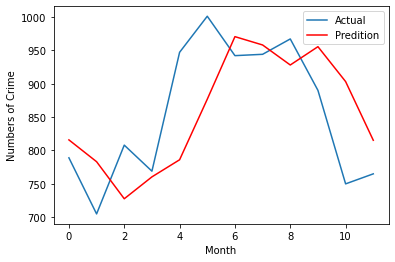

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 18
Actuals: [515, 518, 574, 535, 726, 650, 735, 740, 642, 598, 542, 644]
Predictions: [545.21844, 524.4823, 514.4473, 555.30334, 554.9356, 635.2166, 717.69385, 695.3475, 738.4592, 673.36145, 625.8173, 566.44476]


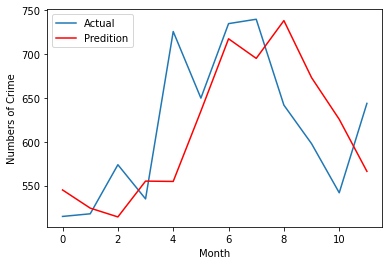

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 19
Actuals: [1386, 1249, 1429, 1536, 1601, 1505, 1655, 1585, 1332, 1269, 1182, 1233]
Predictions: [1328.1476, 1350.9745, 1272.9761, 1332.3048, 1478.9554, 1570.6707, 1507.2319, 1570.0253, 1612.7408, 1431.2153, 1313.9432, 1201.8728]


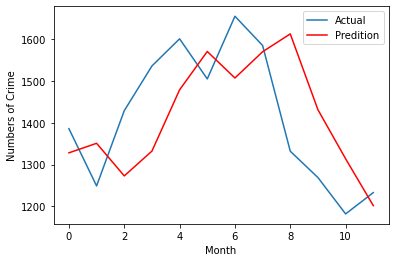

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 20
Actuals: [488, 458, 468, 536, 508, 514, 563, 636, 555, 580, 481, 484]
Predictions: [577.5918, 541.0171, 491.62048, 463.73456, 509.97818, 523.2534, 509.49768, 547.25665, 604.2841, 590.0005, 570.6978, 515.62085]


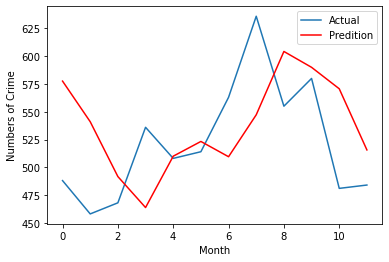

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 21
Actuals: [765, 693, 853, 902, 936, 1135, 1003, 1002, 951, 885, 805, 913]
Predictions: [906.6535, 835.70825, 754.0353, 793.6832, 875.7144, 924.383, 1047.9182, 1054.615, 1000.04614, 952.7438, 902.8831, 836.0327]


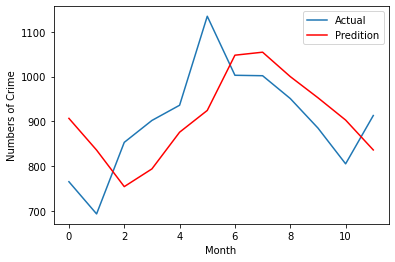

  0%|          | 0/12 [00:00<?, ?it/s]

Borough: 22
Actuals: [667, 599, 754, 784, 853, 837, 929, 843, 836, 736, 690, 727]
Predictions: [699.4254, 681.0667, 628.72174, 696.0227, 771.09875, 827.0131, 846.14655, 896.1728, 878.26904, 833.66833, 767.2697, 715.66046]


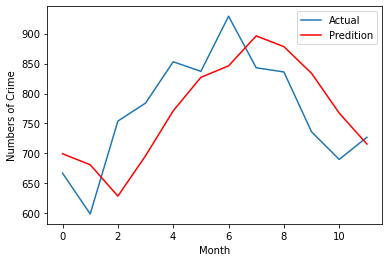

R-squared: 0.907
Mean Absolute Error:68.406
Median Absolute Error:63.249
Mean Squared Error:85.064


In [15]:
# prepare situation
window = 3
predTot = list()
testTot = list()

# walk forward over time steps in test
for distNum in tqdm_notebook(range(len(train_d))):
    
    history = train_d[distNum]
    test = test_d[distNum]
    preds = []
    for t in tqdm_notebook(range(len(test)), leave=False):
        
        length = len(history)
        
        # split into samples
        X, y = split_sequence(history, window)
        
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 1
        X = X.reshape((X.shape[0], X.shape[1], n_features))
        
       
        
        X_test = array([history[i] for i in range(length-window, length)])
        X_test = X_test.reshape((1, window, n_features))
        yhat = model.predict(X_test, verbose=0)
        
        obs = test[t]
        preds.append(yhat.reshape((1,)))
        history.append(obs)
    
    preds_new = [i[0] for i in preds]
    print('Borough: {}'.format(distNum+1))
    print('Actuals: {}'.format(test))
    print('Predictions: {}'.format(preds_new))
    
    # plot
    plt.plot(test)
    plt.plot(preds_new, color='red')
    plt.xlabel("Month")
    plt.ylabel("Numbers of Crime")
    plt.legend(["Actual", "Predition"])
    plt.show()
    
    testTot = testTot + test
    predTot = predTot + preds_new
    
print('R-squared: %.3f' %r2_score(testTot, predTot))
print('Mean Absolute Error:%.3f'%mean_absolute_error(testTot, predTot))
print('Median Absolute Error:%.3f'%median_absolute_error(testTot, predTot))
print('Mean Squared Error:%.3f'%mean_squared_error(testTot, predTot) ** .5)